<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 223688221 bytes
User uploaded file "locations_categorical_features.csv" with length 27878177 bytes
User uploaded file "validation_data.csv" with length 7581347 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [20]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
563834,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
563835,99996800_303056370_189735890,PO16 9PA,FAREHAM
563836,99998470_302856560_189531620,PO16 9UH,FAREHAM
563837,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [21]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60000.000000,56187.500000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0,66.666667,77.975528,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.666667,79000.000000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0,0.421053,0.632911,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.666667,64341.666667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0,74.347333,98.937961,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.666667,101666.666667,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0,67.213115,67.213115,170000.0
4,1,F,S,6.0,55.701643,1.752959,14.0,11.9,11.0,136250.000000,168104.166667,18,4111570000,27468619000,16632627000,51.236727,-0.560636,655000.0,380.733945,289.639361,655000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144234,5,F,D,1.0,0.000000,0.000000,0.0,0.0,0.0,87250.000000,92500.000000,16,18126308000,28825475000,18214946000,50.896436,-2.576097,114000.0,30.659026,23.243243,570000.0
1144235,5,F,D,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.000000,107500.000000,4,25424316000,711278000,10659618000,53.417210,-2.246727,178000.0,69.523810,65.581395,890000.0
1144236,5,F,S,6.0,193.121503,1.094252,26.0,8.7,8.3,89750.000000,92500.000000,9,8815989000,34831047000,24742056000,50.868112,0.567342,65600.0,-26.908078,-29.081081,328000.0
1144237,5,F,D,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.000000,57750.000000,2,29718009000,3717254000,14712579000,53.731672,-2.624259,42800.0,-25.887446,-25.887446,214000.0


In [22]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0,10.175439,-3.754789,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0,98.529412,88.811189,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0,29.380054,50.000000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0,128.223659,108.333333,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0,23.809524,21.188580,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38522,5,F,D,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26,22886393000,4770220000,7212565000,53.060015,-2.388207,78750.0,50.000000,42.319277,393750.0
38523,5,F,S,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,26,8821511000,25299709000,18394460000,52.085717,0.720703,186000.0,101.444043,91.752577,930000.0
38524,5,F,D,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26,6938065000,27433863000,19483321000,51.800099,0.725616,112000.0,6.140178,5.000000,560000.0
38525,5,F,T,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26,7548684000,32765304000,21992537000,50.834805,-0.137428,108400.0,-33.885642,-31.734453,542000.0


In [23]:
#remove outliers
#remove outliers (properties with bedrooms over 5, properties with prices under 10K and over 1M were removed before the train_test data was passed into the routine)
#df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
#df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]
#-------------------------------------------------------------------------------------------------------
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_3mnths'] <=100) ]
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_4mnths'] <=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_3mnths']<=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_4mnths'] <=100) ]

In [24]:
#remove columns: 'this_price_per_bedroom',	'compare_ppd_re_hist_median_3mnths',	'compare_ppd_re_hist_median_4mnths'
df_train_test_data=df_train_test_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)
df_validation_data=df_validation_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)

In [25]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [26]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [27]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [28]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [29]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
33127,1,2,1,6.0,50.415010,0.349427,20.0,9.3,8.3,75500.000000,81770.833333,11,15937064000,10183455000,5283105000,52.771610,-1.286171,104000.0
607156,3,2,2,31.0,52.321475,0.402557,34.0,10.4,8.9,160833.333333,146250.000000,5,1757983000,25645109000,16154894000,51.627981,0.007562,582000.0
506636,3,2,4,1.0,21.040146,3.895985,10.0,11.1,9.7,109166.666667,112166.666667,22,4849993000,21283951000,11209597000,51.832867,-0.646513,342500.0
583966,3,2,3,7.0,62.308781,0.124594,14.0,10.8,10.3,75000.000000,75000.000000,1,11879502000,14243050000,4794963000,52.358830,-1.227128,250000.0
341350,2,2,2,12.0,61.106386,1.754674,32.0,11.4,10.0,43750.000000,51166.666667,5,26947726000,3243137900,11333175000,53.377646,-2.708929,89000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045625,4,2,3,9.0,56.802650,0.964591,32.0,8.4,7.4,103750.000000,109000.000000,22,4362443000,25256378000,14349242000,51.397096,-0.768972,302500.0
1134960,5,2,3,32.0,53.810050,1.023719,30.0,11.5,11.0,156041.666667,156041.666667,1,1435955900,24750760000,14631979000,51.581158,-0.344420,617500.0
229356,2,2,2,16.0,90.049716,0.760070,31.0,10.6,8.3,87500.000000,86083.333333,18,4836264900,21233834000,11689873000,51.906125,-0.469227,167500.0
956050,4,2,4,11.0,79.853672,0.784647,32.0,9.5,8.8,169166.666667,152333.333333,24,7441012000,32573985000,21781416000,50.844221,-0.169781,825000.0


In [30]:
dataset = df_train_test_data.values
dataset

array([[1, '2', '1', ..., 52.771609999999995, -1.286171, 104000.0],
       [3, '2', '2', ..., 51.627981, 0.007562, 582000.0],
       [3, '2', '4', ..., 51.832867, -0.646513, 342500.0],
       ...,
       [2, '2', '2', ..., 51.906125, -0.46922700000000006, 167500.0],
       [4, '2', '4', ..., 50.844221000000005, -0.169781, 825000.0],
       [3, '2', '2', ..., 52.40597, -0.73078, 153000.0]], dtype=object)

In [31]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [32]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [33]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [34]:
from sklearn import preprocessing

In [35]:
min_max_scaler = preprocessing.MinMaxScaler()

In [36]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.        , 1.        , 0.        , ..., 0.13905249, 0.480277  ,
        0.59211122],
       [0.5       , 1.        , 0.33333333, ..., 0.42891301, 0.28314802,
        0.76553543],
       [0.5       , 1.        , 1.        , ..., 0.29706292, 0.31846452,
        0.67785703],
       ...,
       [0.25      , 1.        , 0.33333333, ..., 0.3098679 , 0.3310921 ,
        0.70162212],
       [0.75      , 1.        , 1.        , ..., 0.57892572, 0.14805018,
        0.74176269],
       [0.5       , 1.        , 0.33333333, ..., 0.2115948 , 0.41725111,
        0.66656108]])

In [37]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [38]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [39]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [42]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(717847, 17) (307649, 17) (717847,) (307649,)


In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [44]:
model = Sequential([
    Dense(500, activation='relu', input_shape=X1_train.shape[1:]),
    Dense(1)
])

In [45]:
my_optimizer = keras.optimizers.Adam(learning_rate=0.009)
model.compile(
              loss='mean_squared_error',
               optimizer=my_optimizer)

In [46]:
import numpy as np

In [47]:
X1_train = np.asarray(X1_train).astype('float32')

In [48]:
Y1_train = np.asarray(Y1_train).astype('float32')

In [49]:
X1_test = np.asarray(X1_test).astype('float32')
Y1_test = np.asarray(Y1_test).astype('float32')

In [50]:
hist = model.fit(X1_train, Y1_train,
          epochs=100,
          validation_data=(X1_test, Y1_test))

Epoch 1/100
22433/22433 [==============================] - 54s 2ms/step - loss: 21066665679.3196 - val_loss: 5319924224.0000
Epoch 2/100
22433/22433 [==============================] - 40s 2ms/step - loss: 5050090801.9014 - val_loss: 4748434944.0000
Epoch 3/100
22433/22433 [==============================] - 40s 2ms/step - loss: 4673593061.2520 - val_loss: 4675864064.0000
Epoch 4/100
22433/22433 [==============================] - 40s 2ms/step - loss: 4622999271.4658 - val_loss: 4643024896.0000
Epoch 5/100
22433/22433 [==============================] - 40s 2ms/step - loss: 4621290316.2386 - val_loss: 4613268480.0000
Epoch 6/100
22433/22433 [==============================] - 41s 2ms/step - loss: 4550292130.4506 - val_loss: 4589091328.0000
Epoch 7/100
22433/22433 [==============================] - 39s 2ms/step - loss: 4561128840.2047 - val_loss: 4578899456.0000
Epoch 8/100
22433/22433 [==============================] - 39s 2ms/step - loss: 4511188152.6226 - val_loss: 4558055424.0000
Epoch 9

In [51]:
prediction1=model.predict(X1_test)
#print(prediction1)

In [52]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,2.0,1.0,1.0,65.000000,88.367050,0.159235,37.000000,10.400000,10.800000,197500.000000,182500.000000,17.0,1.279116e+09,2.616542e+10,1.651745e+10,51.566029,-0.003249,445000.0,385245.468750,59754.531250,3.570604e+09,59754.531477,12791160_261654241_165174538
1,2.0,2.0,3.0,8.000000,108.275230,0.973442,15.000001,10.099999,9.100000,124166.664062,114166.664062,7.0,4.493438e+09,2.986420e+10,1.928081e+10,51.109539,-0.189278,330000.0,306935.125000,23064.875000,5.319884e+08,23064.874767,44934380_298642043_192808079
2,3.0,2.0,3.0,9.000000,35.034840,1.899420,14.000000,10.500000,8.900000,125000.007812,125000.007812,1.0,5.289700e+09,2.689914e+10,1.844853e+10,51.736446,0.509133,312500.0,360755.468750,-48255.468750,2.328590e+09,48255.469493,52896998_268991447_184485315
3,3.0,2.0,2.0,13.999999,100.045715,0.869490,19.000000,10.599999,8.400000,55000.000000,57666.667969,24.0,2.920547e+10,5.143511e+09,1.341411e+10,53.479897,-3.028549,170000.0,141966.859375,28033.140625,7.858570e+08,28033.140388,292054651_51435110_134141102
4,4.0,2.0,4.0,1.000000,4.743641,5.635105,13.000000,10.500000,9.799999,95000.000000,97500.000000,16.0,1.651299e+10,2.642481e+10,2.264904e+10,52.623760,1.436700,465000.0,418794.562500,46205.437500,2.134942e+09,46205.437602,165129892_264248074_226490429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,3.0,2.0,4.0,2.000000,61.600483,0.406158,18.000000,9.700000,9.300000,47500.000000,51500.000000,10.0,3.991469e+10,1.663841e+10,2.755783e+10,54.959026,-1.850818,230000.0,199460.671875,30539.328125,9.326506e+08,30539.328087,399146926_166384118_275578307
307645,3.0,2.0,3.0,4.000000,128.184296,2.132586,16.000000,11.099999,9.900001,121250.000000,133750.000000,10.0,8.296730e+09,3.398711e+10,2.337788e+10,50.786469,0.100446,305000.0,357744.281250,-52744.281250,2.781959e+09,52744.280903,82967301_339871130_233778831
307646,3.0,2.0,4.0,11.999999,38.584812,2.769806,31.000000,8.100000,6.800000,136250.000000,153333.343750,10.0,3.884677e+09,2.331455e+10,1.271211e+10,51.605530,-0.709683,765000.0,504912.875000,260087.125000,6.764531e+10,260087.125833,38846769_233145508_127121070
307647,3.0,2.0,3.0,17.000000,86.505264,1.576508,52.999996,8.200000,7.500000,83166.671875,90000.000000,13.0,9.749136e+09,3.032116e+10,1.900061e+10,50.850105,-1.082394,194000.0,253752.718750,-59752.718750,3.570387e+09,59752.719235,97491364_303211602_190006149


In [53]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,1.0,1.0,65.000000,88.367050,0.159235,37.000000,10.400000,10.800000,197500.000000,182500.000000,17.0,1.279116e+09,2.616542e+10,1.651745e+10,51.566029,-0.003249,445000.0,385245.468750,59754.531250,3.570604e+09,59754.531477,12791160_261654241_165174538,NaN,NaN,NaN
1,2.0,2.0,3.0,8.000000,108.275230,0.973442,15.000001,10.099999,9.100000,124166.664062,114166.664062,7.0,4.493438e+09,2.986420e+10,1.928081e+10,51.109539,-0.189278,330000.0,306935.125000,23064.875000,5.319884e+08,23064.874767,44934380_298642043_192808079,NaN,NaN,NaN
2,3.0,2.0,3.0,9.000000,35.034840,1.899420,14.000000,10.500000,8.900000,125000.007812,125000.007812,1.0,5.289700e+09,2.689914e+10,1.844853e+10,51.736446,0.509133,312500.0,360755.468750,-48255.468750,2.328590e+09,48255.469493,52896998_268991447_184485315,NaN,NaN,NaN
3,3.0,2.0,2.0,13.999999,100.045715,0.869490,19.000000,10.599999,8.400000,55000.000000,57666.667969,24.0,2.920547e+10,5.143511e+09,1.341411e+10,53.479897,-3.028549,170000.0,141966.859375,28033.140625,7.858570e+08,28033.140388,292054651_51435110_134141102,NaN,NaN,NaN
4,4.0,2.0,4.0,1.000000,4.743641,5.635105,13.000000,10.500000,9.799999,95000.000000,97500.000000,16.0,1.651299e+10,2.642481e+10,2.264904e+10,52.623760,1.436700,465000.0,418794.562500,46205.437500,2.134942e+09,46205.437602,165129892_264248074_226490429,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,3.0,2.0,4.0,2.000000,61.600483,0.406158,18.000000,9.700000,9.300000,47500.000000,51500.000000,10.0,3.991469e+10,1.663841e+10,2.755783e+10,54.959026,-1.850818,230000.0,199460.671875,30539.328125,9.326506e+08,30539.328087,399146926_166384118_275578307,NaN,NaN,NaN
307645,3.0,2.0,3.0,4.000000,128.184296,2.132586,16.000000,11.099999,9.900001,121250.000000,133750.000000,10.0,8.296730e+09,3.398711e+10,2.337788e+10,50.786469,0.100446,305000.0,357744.281250,-52744.281250,2.781959e+09,52744.280903,82967301_339871130_233778831,NaN,NaN,NaN
307646,3.0,2.0,4.0,11.999999,38.584812,2.769806,31.000000,8.100000,6.800000,136250.000000,153333.343750,10.0,3.884677e+09,2.331455e+10,1.271211e+10,51.605530,-0.709683,765000.0,504912.875000,260087.125000,6.764531e+10,260087.125833,38846769_233145508_127121070,NaN,NaN,NaN
307647,3.0,2.0,3.0,17.000000,86.505264,1.576508,52.999996,8.200000,7.500000,83166.671875,90000.000000,13.0,9.749136e+09,3.032116e+10,1.900061e+10,50.850105,-1.082394,194000.0,253752.718750,-59752.718750,3.570387e+09,59752.719235,97491364_303211602_190006149,NaN,NaN,NaN


In [54]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,1.0,1.0,65.000000,88.367050,0.159235,37.000000,10.400000,10.800000,197500.000000,182500.000000,17.0,1.279116e+09,2.616542e+10,1.651745e+10,51.566029,-0.003249,445000.0,385245.468750,59754.531250,3.570604e+09,59754.531477,12791160_261654241_165174538,NaN,NaN,NaN
1,2.0,2.0,3.0,8.000000,108.275230,0.973442,15.000001,10.099999,9.100000,124166.664062,114166.664062,7.0,4.493438e+09,2.986420e+10,1.928081e+10,51.109539,-0.189278,330000.0,306935.125000,23064.875000,5.319884e+08,23064.874767,44934380_298642043_192808079,NaN,NaN,NaN
2,3.0,2.0,3.0,9.000000,35.034840,1.899420,14.000000,10.500000,8.900000,125000.007812,125000.007812,1.0,5.289700e+09,2.689914e+10,1.844853e+10,51.736446,0.509133,312500.0,360755.468750,-48255.468750,2.328590e+09,48255.469493,52896998_268991447_184485315,NaN,NaN,NaN
3,3.0,2.0,2.0,13.999999,100.045715,0.869490,19.000000,10.599999,8.400000,55000.000000,57666.667969,24.0,2.920547e+10,5.143511e+09,1.341411e+10,53.479897,-3.028549,170000.0,141966.859375,28033.140625,7.858570e+08,28033.140388,292054651_51435110_134141102,NaN,NaN,NaN
4,4.0,2.0,4.0,1.000000,4.743641,5.635105,13.000000,10.500000,9.799999,95000.000000,97500.000000,16.0,1.651299e+10,2.642481e+10,2.264904e+10,52.623760,1.436700,465000.0,418794.562500,46205.437500,2.134942e+09,46205.437602,165129892_264248074_226490429,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,3.0,2.0,4.0,2.000000,61.600483,0.406158,18.000000,9.700000,9.300000,47500.000000,51500.000000,10.0,3.991469e+10,1.663841e+10,2.755783e+10,54.959026,-1.850818,230000.0,199460.671875,30539.328125,9.326506e+08,30539.328087,399146926_166384118_275578307,NaN,NaN,NaN
307645,3.0,2.0,3.0,4.000000,128.184296,2.132586,16.000000,11.099999,9.900001,121250.000000,133750.000000,10.0,8.296730e+09,3.398711e+10,2.337788e+10,50.786469,0.100446,305000.0,357744.281250,-52744.281250,2.781959e+09,52744.280903,82967301_339871130_233778831,NaN,NaN,NaN
307646,3.0,2.0,4.0,11.999999,38.584812,2.769806,31.000000,8.100000,6.800000,136250.000000,153333.343750,10.0,3.884677e+09,2.331455e+10,1.271211e+10,51.605530,-0.709683,765000.0,504912.875000,260087.125000,6.764531e+10,260087.125833,38846769_233145508_127121070,NaN,NaN,NaN
307647,3.0,2.0,3.0,17.000000,86.505264,1.576508,52.999996,8.200000,7.500000,83166.671875,90000.000000,13.0,9.749136e+09,3.032116e+10,1.900061e+10,50.850105,-1.082394,194000.0,253752.718750,-59752.718750,3.570387e+09,59752.719235,97491364_303211602_190006149,NaN,NaN,NaN


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

In [55]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

65481.237127003486

In [56]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.528482133860344 %
Predictions where error is 15% or less :52.838787059278594 %
Predictions where error is 20% or less :65.20092703047953 %
Predictions where error is 50% or more :5.9548381434686934 %


In [57]:
prediction_validation=model.predict(X_Validation_scale)

In [58]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,468912.562500,154913,2.39979e+10,154913,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,246265.312500,21265.3,4.52214e+08,21265.3,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,120723.429688,723.43,523351,723.43,103333010_303705230_190276950
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,43486.207031,-8513.79,7.24847e+07,8513.79,324079420_66042660_170299350
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,147639.140625,14639.1,2.14304e+08,14639.1,274203190_292558650_213750350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,412474.843750,95474.8,9.11545e+09,95474.8,148740500_304966640_192878440
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,417086.343750,23336.3,5.44585e+08,23336.3,228863930_47702200_72125650
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,575173.312500,15173.3,2.30229e+08,15173.3,69380650_274338630_194833210
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,594524.562500,52524.6,2.75883e+09,52524.6,75486840_327653040_219925370


In [59]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,468912.562500,154913,2.39979e+10,154913,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,246265.312500,21265.3,4.52214e+08,21265.3,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,120723.429688,723.43,523351,723.43,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,43486.207031,-8513.79,7.24847e+07,8513.79,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,147639.140625,14639.1,2.14304e+08,14639.1,274203190_292558650_213750350,EX31 1NY,NORTH DEVON,EX31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,412474.843750,95474.8,9.11545e+09,95474.8,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,417086.343750,23336.3,5.44585e+08,23336.3,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,575173.312500,15173.3,2.30229e+08,15173.3,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,594524.562500,52524.6,2.75883e+09,52524.6,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [60]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [61]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

65818.84033889271

In [62]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :37.02243958573072 %
Predictions where error is 15% or less :51.99079401611047 %
Predictions where error is 20% or less :64.25776754890678 %
Predictions where error is 50% or more :6.156501726121979 %


In [63]:
import matplotlib.pyplot as plt

In [64]:
import numpy as np

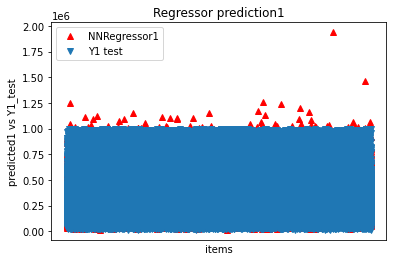

In [65]:
plt.figure()
plt.plot(prediction1, 'r^', label='NNRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

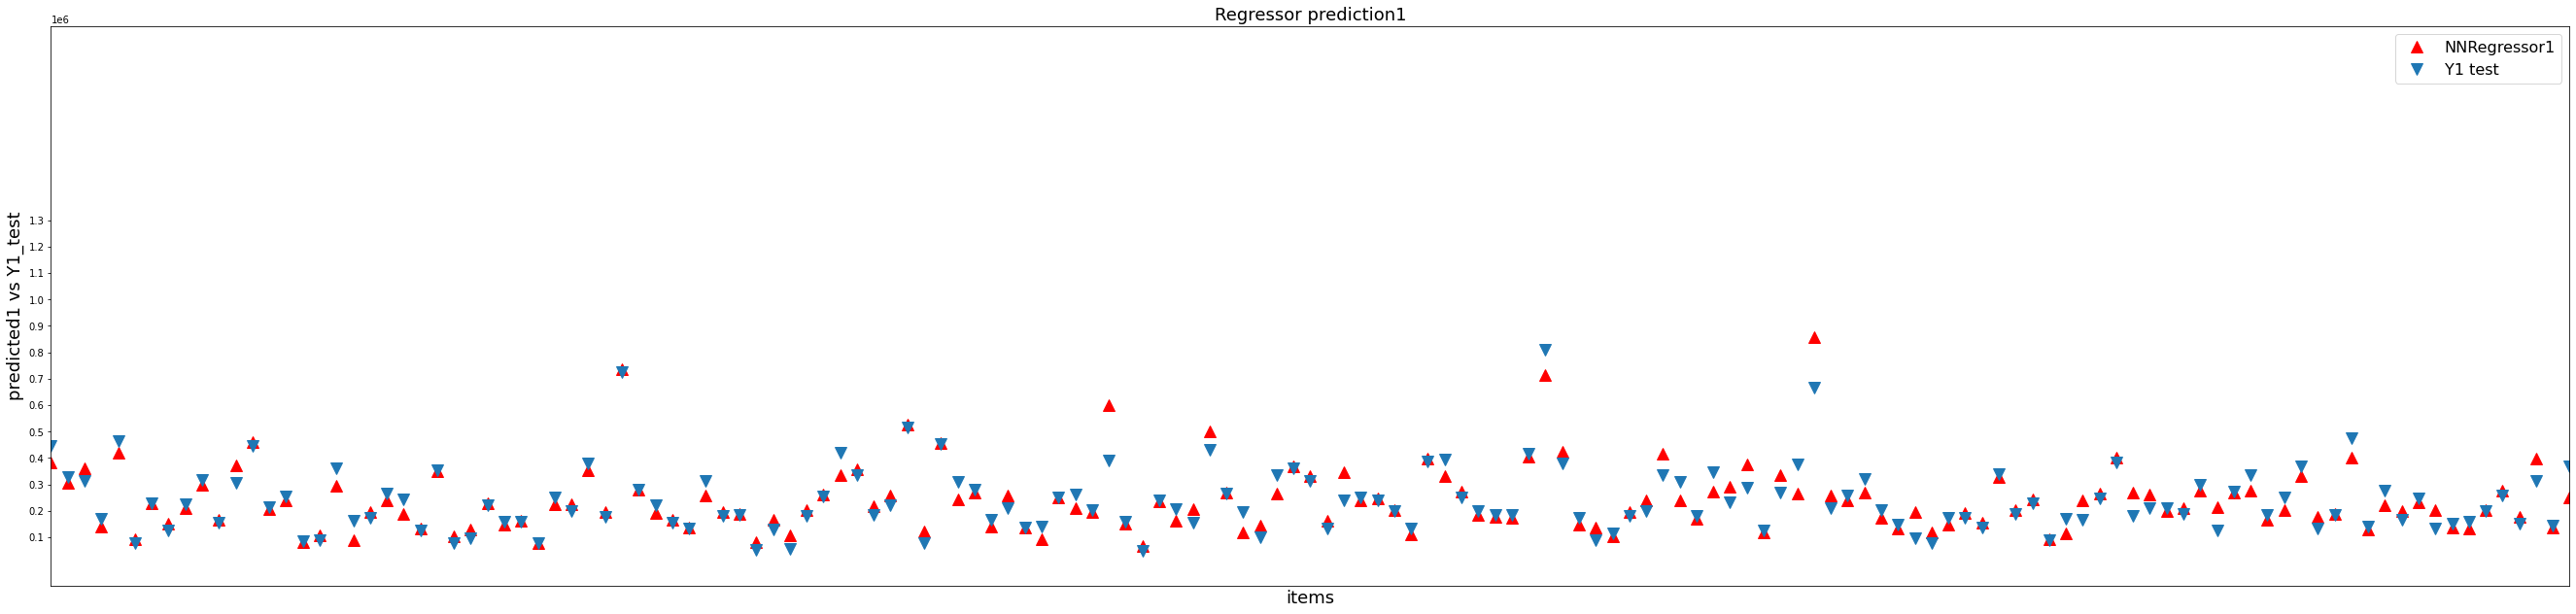

In [66]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='NNRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [67]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [68]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

65481.236885080296

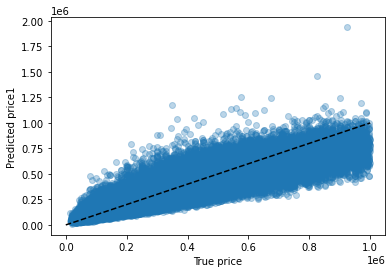

In [69]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [70]:
#test data has several very bad predictions:
#test prediction_90pc_df1
prediction_over90pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=90) ] 
within_90pc_error1=100*prediction_over90pc_df1.shape[0]/prediction_df1.shape[0]
print('Test predictions where error is 90% or more :' + str(within_90pc_error1) + ' %')

Test predictions where error is 90% or more :1.4773329346105464 %


In [71]:
prediction_over90pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
44,3.0,2.0,2.0,21.999998,91.565887,0.941688,55.000000,9.200000,8.600000,46333.335938,42500.000000,15.000000,2.560190e+10,5.782920e+08,1.111494e+10,53.468021,-2.166687,55000.0,109497.132812,-54497.132812,2.969937e+09,54497.132108,256018964_5782920_111149353,99.085695
111,3.0,2.0,4.0,1.000000,11.026527,5.419656,19.000000,11.400000,10.500000,44000.000000,50500.000000,17.000000,2.289095e+10,9.957066e+09,1.410385e+10,53.541458,-0.748819,98000.0,196051.734375,-98051.734375,9.614142e+09,98051.733610,228909507_99570657_141038520,100.052789
184,3.0,2.0,3.0,3.000000,119.658272,1.217725,18.000000,10.500000,9.100000,69625.000000,69250.000000,10.000000,1.202946e+10,3.166982e+10,2.030973e+10,50.694389,-1.293367,101000.0,214704.906250,-113704.906250,1.292881e+10,113704.907053,120294636_316698173_203097334,112.579116
239,3.0,2.0,3.0,35.000000,108.668846,1.147923,52.999996,8.100000,6.900000,64333.335938,69083.335938,18.000000,1.547522e+10,1.156821e+10,7.244790e+08,52.477108,-1.798485,100000.0,200035.031250,-100035.031250,1.000701e+10,100035.030024,154752174_115682130_7244790,100.035030
261,2.0,2.0,2.0,8.000000,140.003998,0.681756,32.000000,9.700000,8.900000,53000.000000,53000.000000,2.000000,3.492621e+10,1.265624e+10,2.304163e+10,54.542351,-1.550977,42000.0,100015.414062,-58015.414062,3.365788e+09,58015.413124,349262111_126562437_230416282,138.131936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307466,4.0,2.0,3.0,6.000000,99.963638,0.660186,15.000001,11.300000,10.400000,82250.000000,85000.000000,9.000000,1.482374e+10,1.356457e+10,2.292898e+09,52.275780,-1.939923,150000.0,309403.093750,-159403.093750,2.540935e+10,159403.091363,148237435_135645665_22928980,106.268728
307481,3.0,2.0,3.0,10.999999,88.012321,2.861104,42.000000,8.600000,8.300000,37500.000000,35000.000000,15.000000,3.631976e+10,1.372821e+10,2.430150e+10,54.660130,-1.626893,42500.0,113821.500000,-71321.500000,5.086756e+09,71321.499928,363197645_137282068_243015004,167.815294
307582,2.0,2.0,2.0,5.000000,198.363312,1.864218,48.000000,9.299999,8.600000,38125.000000,43041.664062,14.000001,3.667277e+10,1.424466e+10,2.477313e+10,54.700512,-1.581679,36000.0,68629.593750,-32629.593750,1.064690e+09,32629.593439,366727700_142446561_247731323,90.637760
307588,3.0,1.0,1.0,65.000000,115.733017,0.235710,36.000000,14.000000,11.500000,301250.000000,295000.031250,25.000000,4.516400e+08,2.583996e+10,1.596528e+10,51.547562,-0.132408,285000.0,652682.062500,-367682.062500,1.351901e+11,367682.066487,4516400_258399560_159652751,129.011251


In [72]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

65818.84033889318

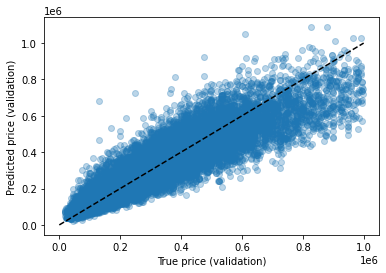

In [73]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()

In [74]:
#validation data has several very bad predictions:
#validation prediction_90pc_df1
prediction_over90pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=90) ] 
within_90pc_error1_val=100*prediction_over90pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 90% or more :' + str(within_90pc_error1_val) + ' %')

Predictions where error is 90% or more :1.493095512082854 %


In [75]:
prediction_over90pc_df1_val

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,error_perc
16,1.0,1.0,1.0,18.0,88.726289,0.888273,12.0,11.8,11.2,88750.000000,75187.500000,26.0,3.982967e+10,1.783974e+10,2.833047e+10,55.013802,-1.439469,49500,111470.171875,61970.2,3.8403e+09,61970.2,398296690_178397430_283304660,125.192
48,1.0,1.0,1.0,53.0,104.698370,0.644203,53.0,11.7,8.6,710000.000000,254166.666667,26.0,2.689830e+08,2.583653e+10,1.580284e+10,51.519313,-0.205359,367500,748686.500000,381186,1.45303e+11,381186,2689830_258365270_158028430,103.724
66,1.0,1.0,1.0,4.0,55.348145,1.221984,15.0,11.6,9.9,108250.000000,139375.000000,26.0,1.456350e+10,2.377370e+10,1.287144e+10,51.343100,-2.250522,74000,146769.453125,72769.5,5.29539e+09,72769.5,145634970_237736980_128714370,98.3371
156,1.0,1.0,1.0,4.0,55.348145,1.221984,15.0,11.6,9.9,108250.000000,139375.000000,26.0,1.456350e+10,2.377370e+10,1.287144e+10,51.343100,-2.250522,75000,146769.453125,71769.5,5.15085e+09,71769.5,145634970_237736980_128714370,95.6926
159,1.0,1.0,1.0,6.0,75.156867,0.453190,23.0,9.9,8.3,122000.000000,108750.000000,26.0,6.681220e+09,1.934935e+10,9.718739e+09,52.018293,-0.693980,58500,143499.921875,84999.9,7.22499e+09,84999.9,66812200_193493480_97187390,145.299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34664,5.0,2.0,4.0,23.0,106.495958,0.424742,72.0,8.2,7.6,57333.333333,55833.333333,26.0,2.850524e+10,5.328915e+09,1.262060e+10,53.386753,-3.039939,162000,354059.250000,192059,3.68868e+10,192059,285052449_53289150_126205970,118.555
34713,5.0,2.0,2.0,14.0,98.318898,1.489947,60.0,11.8,9.5,41166.666667,39000.000000,26.0,3.473978e+10,1.344772e+10,2.343772e+10,54.559854,-1.320500,89000,188725.078125,99725.1,9.94509e+09,99725.1,347397750_134477230_234377160,112.051
34730,5.0,1.0,2.0,10.0,56.960515,1.130315,33.0,8.4,6.8,50500.000000,58325.000000,26.0,2.939118e+10,3.483122e+09,1.483113e+10,53.779837,-2.410257,113500,233293.203125,119793,1.43504e+10,119793,293911850_34831220_148311340,105.545
34743,5.0,2.0,4.0,9.0,63.496471,2.380537,21.0,10.1,9.0,49125.000000,55000.000000,26.0,3.268831e+10,6.852067e+09,1.732730e+10,53.883061,-3.039913,160000,364562.312500,204562,4.18457e+10,204562,326883130_68520670_173273010,127.851
